In [1]:
import pyro
import torch
import normflows as nf
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import yaml
import corner
import random
import pandas as pd
from collections import defaultdict
import numpy as np
mpl.rcParams["figure.dpi"] = 100

from grad_june import Runner

#torch.autograd.detect_anomaly(check_nan=True)

/cosma/home/dp004/dc-quer1/.conda/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:0"

In [3]:
def set_random_seed(seed=999):
    """
    Sets global seeds for testing in numpy, random, and numbaized numpy.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    return
#set_random_seed()

In [4]:
def plot_posterior(nfm, it, lims=(0,2)):
    posteriors = nfm.sample(10000)
    samples = posteriors[0].cpu().detach().numpy()
    samples = np.where(~np.isnan(samples), samples, 0)
    samples = np.where(~np.isinf(samples), samples, 0)
    samples = np.where(np.abs(samples) < 5, samples, 0)
    f = corner.corner(samples, labels = param_names, 
                      smooth=2, 
                      truths=true_values,
                      show_titles=True,
                      bins=30,
                      range = [lims for i in range(len(true_values))])
    #f.savefig(f"./flow_results/posteriors/posterior_{it:03d}.png", dpi=150, facecolor='white')
    return

In [5]:
true_parameters = {}
#true_parameters = {
#  "care_home":
#    {"log_beta": 1.3054601},
#  "care_visit":
#    {"log_beta": 0.46661767},
#  "cinema":
#    {"log_beta": 0.7523964},
#  "company":
#    {"log_beta": 0.3428555},
#  "grocery":
#    {"log_beta": 0.7523964},
#  "gym":
#    {"log_beta": 0.7523964},
#  "household":
#    {"log_beta": 0.30810425},
#  "pub":
#    {"log_beta": 0.7523964},
#  "school":
#    {"log_beta": 0.4572914},
#  "university":
#    {"log_beta": 0.34417054},
#  "visit":
#    {"log_beta": 0.7523964},
#}
true_parameters["household"] = {"log_beta" : 1.0}
true_parameters["company"] = {"log_beta" : 1.0}
true_parameters["school"] = {"log_beta" : 1.0}
#true_parameters["pub"] = {"log_beta" : 1.0}
#true_parameters["visit"] = {"log_beta" : 1.0}




n_true_parameters = len(true_parameters)
true_values = np.array([true_parameters[key]["log_beta"] for key in true_parameters])
param_names = list(true_parameters.keys())
n_true_parameters
true_values

array([1., 1., 1.])

In [6]:
#params = yaml.safe_load(open("../configs/june.yaml"))
params = yaml.safe_load(open("../configs/best_run.yaml"))
params["timer"]["total_days"] = 10
params["system"]["device"] = device
#params["data_path"] = "/cosma/home/dp004/dc-quer1/gradabm-june/test/data/data.pkl"
params["data_path"] = "/cosma7/data/dp004/dc-quer1/torch_june_worlds/data_camden.pkl"

for key in true_parameters:
    params["networks"][key] = true_parameters[key]
runner = Runner.from_parameters(params)

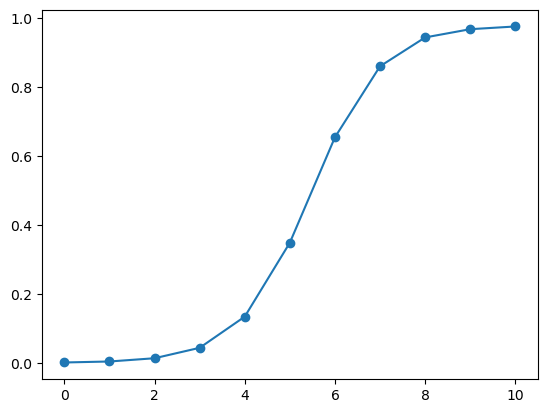

In [7]:
true_data = runner()[0]["cases_per_timestep"]
n_people = runner.n_agents
true_data = true_data / n_people
plt.plot(true_data.detach().cpu(), "o-")

In [8]:
prior = torch.distributions.Normal(torch.zeros(n_true_parameters, device=device), torch.ones(n_true_parameters, device=device))

/cosma/home/dp004/dc-quer1/.conda/envs/ml/lib/python3.9/site-packages/normflows/flows/mixing.py:437: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484806139/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  outputs, _ = torch.triangular_solve(


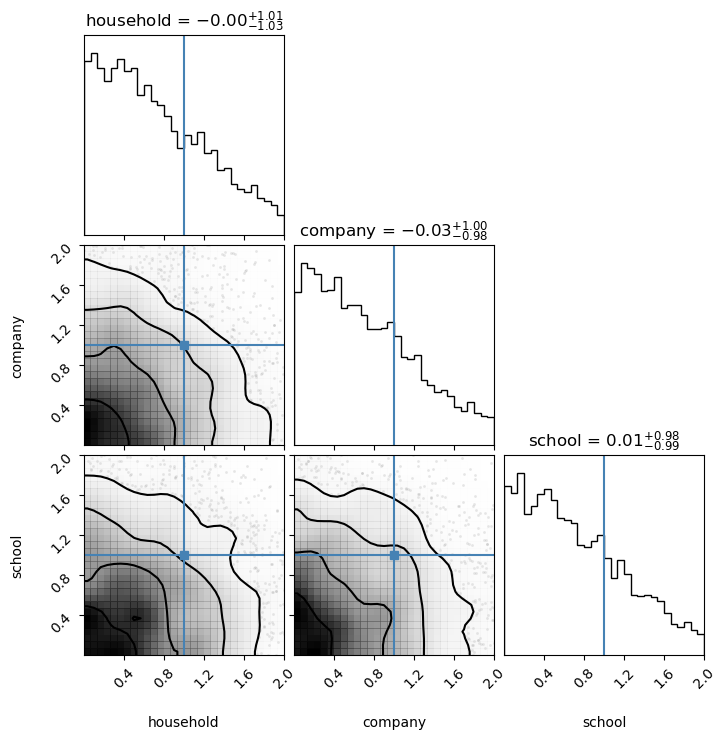

In [9]:
# Set up model

# Define flows
K = 4

latent_size = len(true_values)
hidden_units = 32
hidden_layers = 2

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set prior and q0
q0 = nf.distributions.DiagGaussian(len(true_values), trainable=False)

# Construct flow model
flow = nf.NormalizingFlow(q0=q0, flows=flows)

# Move model on GPU if available
flow = flow.to(device)

plot_posterior(flow, 0)
plt.show()

In [10]:
def run_model(sample):
    #print(sample)
    sample = sample.flatten()
    for (j, name) in enumerate(true_parameters):
        runner.model.infection_networks.networks[name].log_beta = sample[j]
    cases_per_timestep = runner()[0]["cases_per_timestep"] / n_people
    return cases_per_timestep

def get_forecast_score(flow, true_data, loss_fn, n_samples=5):
    loss = 0.0
    for i in range(n_samples):
        sample, lp = flow.sample()
        #print(sample)
        cases_per_timestep = run_model(sample)
        #print(cases_per_timestep)
        loss += loss_fn(cases_per_timestep, true_data)
        #print(loss)
    return loss / n_samples

def get_regularisation(flow, n_samples=5):
    samples, flow_lps = flow.sample(n_samples)
    prior_lps = prior.log_prob(samples).sum(1)
    kl = torch.mean(flow_lps - prior_lps)
    return kl


In [11]:
losses = defaultdict(list)
best_loss = np.inf

In [ ]:
# Train model

parameters_to_optimize = list(flow.parameters())
print(sum([len(a) for a in parameters_to_optimize]))
optimizer = torch.optim.Adam(parameters_to_optimize, lr=1e-3)
loss_fn = torch.nn.MSELoss(reduction="mean")


n_epochs = 250
n_samples_per_epoch = 10
n_samples_reg = 10


w = 0.0 #torch.tensor(1.0, requires_grad=True)

iterator = tqdm(range(n_epochs))

for it in iterator:
    optimizer.zero_grad()
    forecast_loss = get_forecast_score(flow=flow, true_data=true_data, loss_fn=loss_fn, n_samples=n_samples_per_epoch)
    reglrise_loss = get_regularisation(flow=flow, n_samples=n_samples_reg)
    loss = forecast_loss  + w * reglrise_loss
    losses["forecast_train"].append(forecast_loss.item())
    losses["reglrise_train"].append(reglrise_loss.item())
    #print(loss)
    if torch.isnan(loss):
        print("loss is nan!")
        break
    loss.backward()

    optimizer.step()
    
    with torch.no_grad():
        val_forecast_loss = get_forecast_score(flow=flow, true_data=true_data, loss_fn=loss_fn, n_samples=n_samples_per_epoch)
        val_reglrise_loss = get_regularisation(flow=flow, n_samples=n_samples_reg)
        val_loss = val_forecast_loss + w * val_reglrise_loss
        
        losses["forecast_val"].append(val_forecast_loss.item())
        losses["reglrise_val"].append(val_reglrise_loss.item())

        if val_loss.item() < best_loss:
            torch.save(flow.state_dict(), "./best_model.pth")
            best_loss = val_loss.item()
        iterator.set_postfix({"fl":forecast_loss.item(), 
                              "rl":reglrise_loss.item(), 
                              "val loss":val_loss.item(), 
                              "best val loss":best_loss})
    df = pd.DataFrame(losses)
    df.to_csv("./losses.csv")

1880


  3%| | 8/250 [01:39<46:40, 11.57s/it, fl=0.0251, rl=0.697, val loss=0.0288, best val loss=0.

In [ ]:
flow.load_state_dict(torch.load("./best_model.pth"))

In [ ]:
plot_posterior(flow, 0, lims=(-2,3))

In [ ]:
n_plot = 20
fig, ax = plt.subplots()

for i in range(n_plot):

    best_params_sample, log_prob = flow.sample()
    cases = run_model(best_params_sample)
    ax.plot(cases.detach().cpu())

ax.plot(true_data.cpu(), color = "black", linewidth=2)